## Importing Libraries and Data

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
import graphviz

In [79]:
df = pd.read_csv('./data/mergeddata.csv')

## Dropping columns unrelated to the models and binning features 

In [80]:
#dropping columns not related to the models

df.drop(columns = ['Unnamed: 0', 'is_closed', 'coordinates', 'latitude', 'longitude', 'zip_code', 'url', 'transactions', 'location'], inplace = True)

In [81]:
#binning the transactions into the total number as it worked well in our statistical tests

df['num_transaction'] = df['delivery'] + df['restaurant_reservation'] + df['pickup']
df.drop(columns = ['delivery', 'restaurant_reservation', 'pickup'], inplace = True)

In [82]:
#binning ratings into statistically similar categories

df['rating'] = df.rating.apply(lambda x: 3 if x < 3 else x)
df['rating'] = df.rating.apply(lambda x: 5 if x > 4 else x)

## Performing a train test split, creating dummy columns and scaling

In [83]:
#setting variables for modeling and performing a train test split

X = df.drop(columns = ['permanently closed', 'alias', 'name'])
y = df['permanently closed']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7, stratify = y, random_state = 2)

In [84]:
X_train.shape

(951, 9)

In [85]:
X_test.shape

(409, 9)

In [86]:
y_train.value_counts()

0    820
1    131
Name: permanently closed, dtype: int64

In [87]:
y_test.value_counts()

0    353
1     56
Name: permanently closed, dtype: int64

In [88]:
#creating copies without dummies to use in Decision Tree models

X_train1 = X_train.copy()
X_test1 = X_test.copy()

In [89]:
#breaking out dummy columns in separate dataframes in order to add and subtract as necessary

price_dummies = pd.get_dummies(X_train.price_cat, drop_first=True)
X_train.drop(columns = 'price_cat', inplace=True)

testprice_dummies = pd.get_dummies(X_test.price_cat, drop_first= True)
X_test.drop(columns = 'price_cat', inplace= True)

cat_dummies = pd.get_dummies(X_train.categories, drop_first= True)
X_train.drop(columns= 'categories', inplace = True)

testcat_dummies = pd.get_dummies(X_test.categories, drop_first=True)
X_test.drop(columns= 'categories', inplace = True)

rating_dummies = pd.get_dummies(X_train.rating, drop_first=True)
X_train.drop(columns = 'rating', inplace = True)

testrating_dummies = pd.get_dummies(X_test.rating, drop_first=True)
X_test.drop(columns = 'rating', inplace = True)

transaction_dummies = pd.get_dummies(X_train.num_transaction, drop_first=True)
X_train.drop(columns = 'num_transaction', inplace = True)

testtransaction_dummies = pd.get_dummies(X_test.num_transaction, drop_first=True)
X_test.drop(columns = 'num_transaction', inplace = True)

In [90]:
#creating variant sets including all dummy variables

X_train_maxft = pd.concat([X_train, price_dummies, cat_dummies, rating_dummies, transaction_dummies], axis = 1)
X_test_maxft = pd.concat([X_test, testprice_dummies, testcat_dummies, testrating_dummies, testtransaction_dummies], axis = 1)

#adding category dummiers to the Decision Tree set and making the price category numerical

X_train1 = pd.concat([X_train1, cat_dummies], axis = 1)
X_train1.drop(columns= 'categories', inplace = True)

X_test1 = pd.concat([X_test1, testcat_dummies], axis = 1)
X_test1.drop(columns= 'categories', inplace = True)

choices = [0,1,2,3,4]
conds = [X_train1.price_cat == 'missing', 
         X_train1.price_cat == 'one', 
         X_train1.price_cat == 'two',
         X_train1.price_cat == 'three',
         X_train1.price_cat == 'four']

X_train1['price_cat'] = np.select(conds, choices)

choices1 = [0,1,2,3,4]
conds1 = [X_test1.price_cat == 'missing', 
         X_test1.price_cat == 'one', 
         X_test1.price_cat == 'two',
         X_test1.price_cat == 'three',
         X_test1.price_cat == 'four']

X_test1['price_cat'] = np.select(conds1, choices1)

## Modeling

In [91]:
#running a recursive feature eliminator to identify any columns not relevant to the model

rfelg = LogisticRegression(random_state=2)

select = RFECV(estimator = rfelg, step = 1, cv = 10, scoring = 'recall', verbose = 1, n_jobs=-1)

select.fit(X_train_maxft, y_train)

selected_columns = X_train_maxft.columns[select.support_]
removed_columns = X_train_maxft.columns[~select.support_]

Fitting estimator with 38 features.


In [92]:
#only one dummy column is selected by the RFECV. Leaving it in for now.

removed_columns

Index(['Noodles'], dtype='object')

In [93]:
#fitting a logistic regression model with all features and dummies

lr = LogisticRegression(random_state=2, class_weight= 'balanced', penalty='l2', C= .6, solver = 'liblinear')

lr.fit(X_train_maxft, y_train)

train_pred = lr.predict(X_train_maxft)
test_pred = lr.predict(X_test_maxft)

print(metrics.accuracy_score(y_train, train_pred))
print(metrics.accuracy_score(y_test, test_pred))

print(metrics.precision_score(y_train, train_pred))
print(metrics.precision_score(y_test, test_pred))

print(metrics.recall_score(y_train, train_pred))
print(metrics.recall_score(y_test, test_pred))

0.7886435331230284
0.8068459657701712
0.3841059602649007
0.4049586776859504
0.8854961832061069
0.875


The model is performing relatively well. In some iterations recall (our target) performs substantially better but at the cost of wildly overpredicting closures. While we are able to make inferences from this based on the common attributes of a surviving business, we've opted for overall better performing models in order to capture more of the relationships between the features and our target.

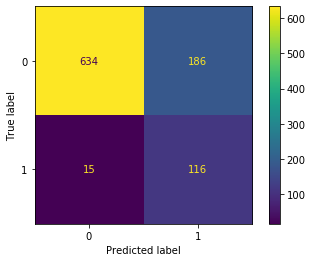

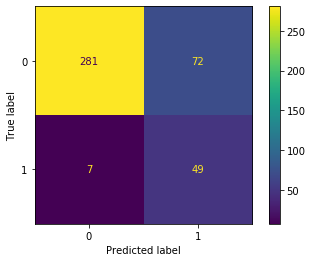

In [94]:
metrics.plot_confusion_matrix(lr, X_train_maxft, y_train)
metrics.plot_confusion_matrix(lr, X_test_maxft, y_test)

Next, we fit a Decision Tree. After dozens of iterations we were able to make a few inferences about non-linear relationships, particularly because several of the very low-performing features in the logistic regression model ended up being first- or second-tier splits in the Decision Tree. 

In [127]:
dtc = DecisionTreeClassifier(random_state=2, max_leaf_nodes=15, max_features=12, class_weight='balanced', criterion='gini')

dtc.fit(X_train1, y_train)

dtc_trainpred = dtc.predict(X_train1)
dtc_testpred = dtc.predict(X_test1)

print(metrics.accuracy_score(y_train, dtc_trainpred))
print(metrics.accuracy_score(y_test, dtc_testpred))

print(metrics.precision_score(y_train, dtc_trainpred))
print(metrics.precision_score(y_test, dtc_testpred))

print(metrics.recall_score(y_train, dtc_trainpred))
print(metrics.recall_score(y_test, dtc_testpred))

0.7592008412197687
0.7579462102689487
0.3567251461988304
0.34074074074074073
0.9312977099236641
0.8214285714285714


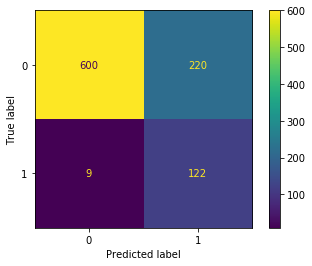

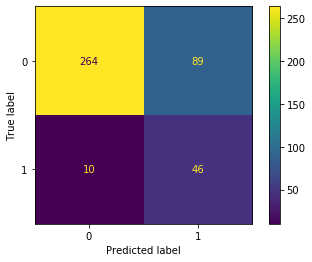

In [128]:
metrics.plot_confusion_matrix(dtc, X_train1, y_train)
metrics.plot_confusion_matrix(dtc, X_test1, y_test)

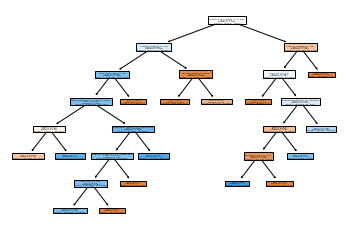

In [129]:
tree.plot_tree(dtc, filled= True, feature_names=X_train1.columns);

In [130]:

tree_data = tree.export_graphviz(dtc, out_file=None, feature_names=X_test1.columns, filled = True, rounded= True, special_characters= True) 
graph = graphviz.Source(tree_data) 

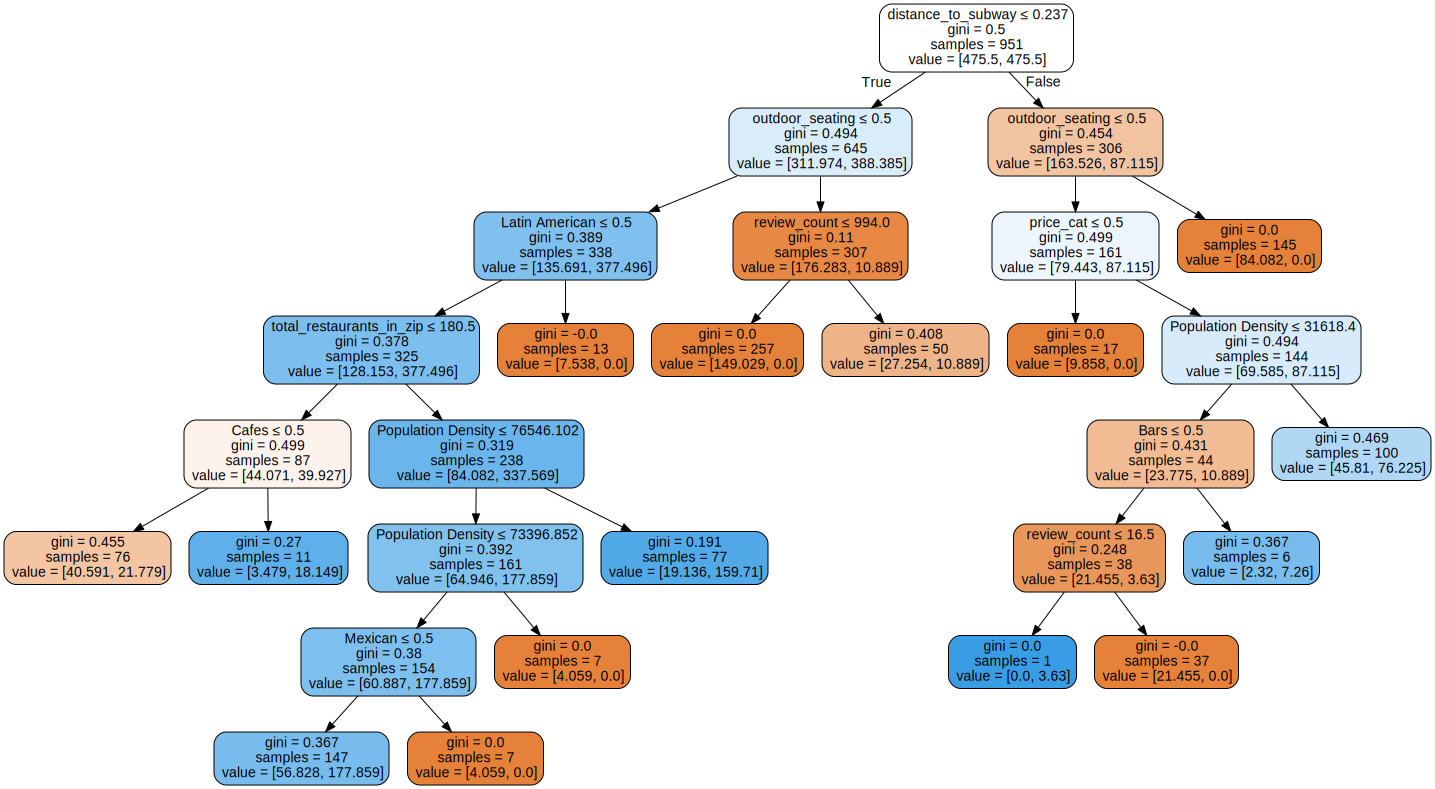

In [131]:
graph

In feature trials the logistic regression model, removing the distance to subway feature actually improved our scores across three metrics, but here we see the Decision Tree splitting on it. When distance to subway was removed from the Decision Tree model, the scores dropped 10+ points across the board. Additional statistical tests revealed stronger correlation at the top and bottom ends, so we decided to create dummies at the point of split in our Decision Tree and re-run the LR model with it. 

In [132]:
X_train_maxft['subwaydist'] = X_train_maxft.distance_to_subway.apply(lambda x: 0 if x <= 0.585 else 1)
X_train_maxft_mod = X_train_maxft.drop(columns = 'distance_to_subway')

X_test_maxft['subwaydist'] = X_test_maxft.distance_to_subway.apply(lambda x: 0 if x <= 0.585 else 1)
X_test_maxft_mod = X_test_maxft.drop(columns = 'distance_to_subway')

In [137]:
lr = LogisticRegression(random_state=2, class_weight= 'balanced', penalty='l2', C= .9, solver = 'liblinear')

lr.fit(X_train_maxft_mod, y_train)

train_pred = lr.predict(X_train_maxft_mod)
test_pred = lr.predict(X_test_maxft_mod)

print(metrics.accuracy_score(y_train, train_pred))
print(metrics.accuracy_score(y_test, test_pred))

print(metrics.precision_score(y_train, train_pred))
print(metrics.precision_score(y_test, test_pred))

print(metrics.recall_score(y_train, train_pred))
print(metrics.recall_score(y_test, test_pred))

# 0.7907465825446898
# 0.8019559902200489
# 0.3835616438356164
# 0.3983739837398374
# 0.8549618320610687
# 0.875 scores from before dummying distance to subway

0.7960042060988434
0.80440097799511
0.3917525773195876
0.4
0.8702290076335878
0.8571428571428571


This gave us a slight boost in accuracy and precision.

## Evaluating our model coefficients

In [ ]:
#conclusions

In [138]:
coef_dict = {}
for i in range(0, len(lr.coef_[0])):
    coef_dict.update({X_test_maxft_mod.columns[i]:lr.coef_[0][i]})
coef_dict

{'review_count': -0.00034199182592915416,
 'outdoor_seating': -3.747055142964748,
 'total_restaurants_in_zip': 0.0047843204721354435,
 'Population Density': 6.640850543741621e-06,
 'missing': -0.44083082518974465,
 'one': -0.1752374834220647,
 'three': 0.053456194795287355,
 'two': 0.01989929767381263,
 'American (Casual)': -0.30327348415818933,
 'American (New)': 0.291547054127628,
 'Bakeries and Desserts': 0.49519422081861936,
 'Bars': 0.5685592344189035,
 'Breakfast & Brunch': 0.42619051331741004,
 'Cafes': 1.1420866499118494,
 'Caribbean': -0.7252719840325453,
 'Chinese': -0.816133878584147,
 'Eastern Europe/Central Asia': -0.2630978938186824,
 'European': -0.305959726592292,
 'Japanese': -0.02083333892541792,
 'Korean': 0.5895367764099442,
 'Latin American': -1.4179158895520771,
 'Mexican': -0.784735548186787,
 'Middle Eastern/Mediterranean': -0.03525500509149783,
 'Misc': -0.3648849649331423,
 'Mobile, Events and Venues': -0.12582969302327202,
 'Noodles': 0.10777968581751023,
 'P